In [75]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42) # Set random seed for reproducibility

In [111]:
# 1. Dataset generate for both model A and B
def generate_multiclass_data(n_samples=1000, n_features=2, n_classes=5):


    X = np.zeros((n_samples, n_features))
    y = np.zeros((n_samples, n_classes))
    y_labels = np.zeros(n_samples)

    samples_per_class = n_samples // n_classes

    # Define centers for 5 clusters
    centers = [[2, 2], [8, 8], [2, 8], [8, 2], [5, 5]]

    for i in range(n_classes):
        start = i * samples_per_class
        end = (i + 1) * samples_per_class

 # Generate random points around the center

        X[start:end] = np.random.randn(samples_per_class, n_features) * 0.7 + centers[i]

        y[start:end, i] = 1  # One-hot encoding
        y_labels[start:end] = i

    return X, y, y_labels

def train_test_split_custom(X, y, y_labels, ratio=0.7):
    "Splits data into training and testing sets manually."
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    split_idx = int(X.shape[0] * ratio)
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]

    return (X[train_idx], y[train_idx], y_labels[train_idx],
            X[test_idx], y[test_idx], y_labels[test_idx])

# Generate Data
X_raw, y_raw, y_labels_raw = generate_multiclass_data(1000, 2, 5)
X_train, y_train, y_train_lbl, X_test, y_test, y_test_lbl = train_test_split_custom(X_raw, y_raw, y_labels_raw)

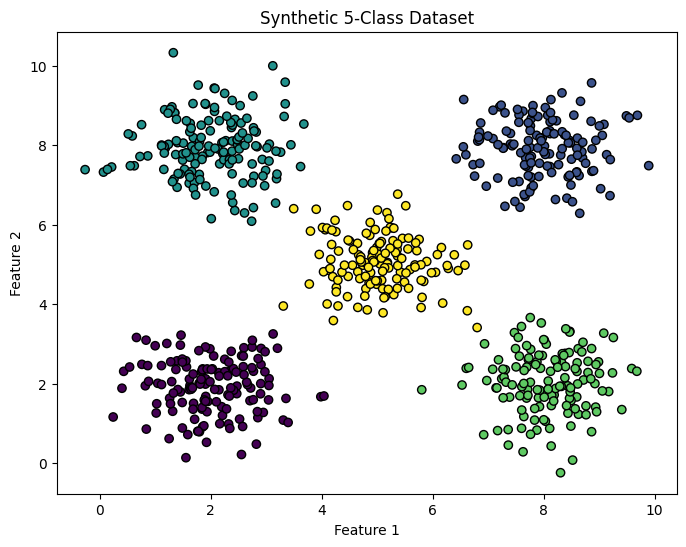

In [112]:
#plot to visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_lbl, cmap='viridis', edgecolors='k')
plt.title("Synthetic 5-Class Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [113]:
# 2. NEURAL NETWORK
# A model
class NeuralNetwork_MultiClass(object):
    def __init__(self, input_size=2, hidden_size=30, output_size=5, learning_rate=0.0005):
        #Input -> H1 -> H2 -> H3 -> Output
        self.inputLayerNeurons = input_size
        self.hiddenLayerNeurons = hidden_size
        self.outLayerNeurons = output_size
        self.learning_rate = learning_rate

        self.W_IH1 = np.random.randn(self.inputLayerNeurons, self.hiddenLayerNeurons) * 0.1
        self.W_H1H2 = np.random.randn(self.hiddenLayerNeurons, self.hiddenLayerNeurons) * 0.1
        self.W_H2H3 = np.random.randn(self.hiddenLayerNeurons, self.hiddenLayerNeurons) * 0.1
        self.W_H3O = np.random.randn(self.hiddenLayerNeurons, self.outLayerNeurons) * 0.1


    def sigmoid(self, x, der=False):
        if der == True:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        #Softmax activation for output layer (Multi-class).
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        # 1. Input - Hidden 1
        self.h1_input = np.dot(X, self.W_IH1)
        self.h1_output = self.sigmoid(self.h1_input)

        # 2. Hidden 1 - Hidden 2
        self.h2_input = np.dot(self.h1_output, self.W_H1H2)
        self.h2_output = self.sigmoid(self.h2_input)

        # 3. Hidden 2 - Hidden 3
        self.h3_input = np.dot(self.h2_output, self.W_H2H3)
        self.h3_output = self.sigmoid(self.h3_input)

        # 4. Hidden 3 - Output
        self.out_input = np.dot(self.h3_output, self.W_H3O)
        self.pred = self.softmax(self.out_input)

        return self.pred

    def backPropagation(self, X, Y, pred):
      # Error at Output (Cross Entropy + Softmax derivative is pred - Y)
        output_error = pred - Y
        output_delta = output_error

     # Propagate back through layers
        h3_error = output_delta.dot(self.W_H3O.T)
        h3_delta = h3_error * self.sigmoid(self.h3_output, der=True)

        h2_error = h3_delta.dot(self.W_H2H3.T)
        h2_delta = h2_error * self.sigmoid(self.h2_output, der=True)

        h1_error = h2_delta.dot(self.W_H1H2.T)
        h1_delta = h1_error * self.sigmoid(self.h1_output, der=True)

      #update weights
        self.W_H3O  -= self.learning_rate * self.h3_output.T.dot(output_delta)
        self.W_H2H3 -= self.learning_rate * self.h2_output.T.dot(h3_delta)
        self.W_H1H2 -= self.learning_rate * self.h1_output.T.dot(h2_delta)
        self.W_IH1  -= self.learning_rate * X.T.dot(h1_delta)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)


Epoch 0, Loss: 1.6101
Epoch 200, Loss: 1.6002
Epoch 400, Loss: 1.1040
Epoch 600, Loss: 0.3458
Epoch 800, Loss: 0.1441
Epoch 1000, Loss: 0.0856
Epoch 1200, Loss: 0.1699
Epoch 1400, Loss: 0.0631
Epoch 1600, Loss: 0.1672
Epoch 1800, Loss: 0.0345
Epoch 2000, Loss: 0.1160
Epoch 2200, Loss: 2.7683
Epoch 2400, Loss: 0.0246
Epoch 2600, Loss: 0.0199
Epoch 2800, Loss: 0.0171


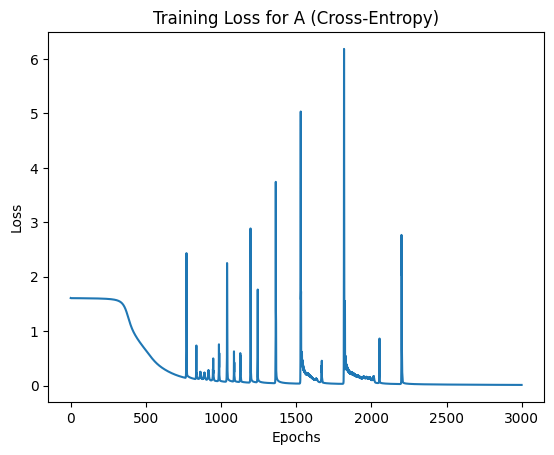

In [114]:
# A Model 3. TRAINING  (less lr and high epochs)
NN = NeuralNetwork_MultiClass(input_size=2, hidden_size=30, output_size=5, learning_rate=0.0005)
loss_history = []
epochs = 3000
for i in range(epochs):
    NN.train(X_train, y_train)

    # Calculate Loss for graph
    predictions = NN.feedForward(X_train)
    epsilon = 1e-15
    clipped_preds = np.clip(predictions, epsilon, 1 - epsilon)
    loss = -np.mean(np.sum(y_train * np.log(clipped_preds), axis=1))
    loss_history.append(loss)

    if i % 200 == 0:
        print(f"Epoch {i}, Loss: {loss:.4f}")
# Plot Loss Curve
plt.plot(loss_history)
plt.title("Training Loss for A (Cross-Entropy)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [115]:
# A model 4. EVALUATION & METRICS
#Prediction on test data
test_probs = NN.feedForward(X_test)
y_pred_indices = np.argmax(test_probs, axis=1)
y_true_indices = np.argmax(y_test, axis=1)

# Helper function for metrics
def calculate_metrics(y_true, y_pred, n_classes=5):
  #  print("\nPerformance Metrics")

    accuracy = np.mean(y_true == y_pred)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    precisions = []
    recalls = []
    f1_scores = []

    for c in range(n_classes):
        # True Positive, False Positive, False Negative
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"Class {c} | Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

In [116]:
# Calculate Metrics
calculate_metrics(y_true_indices, y_pred_indices, n_classes=5)

Overall Accuracy: 99.33%
Class 0 | Precision: 1.00, Recall: 1.00, F1: 1.00
Class 1 | Precision: 1.00, Recall: 1.00, F1: 1.00
Class 2 | Precision: 0.98, Recall: 1.00, F1: 0.99
Class 3 | Precision: 0.99, Recall: 1.00, F1: 0.99
Class 4 | Precision: 1.00, Recall: 0.97, F1: 0.98


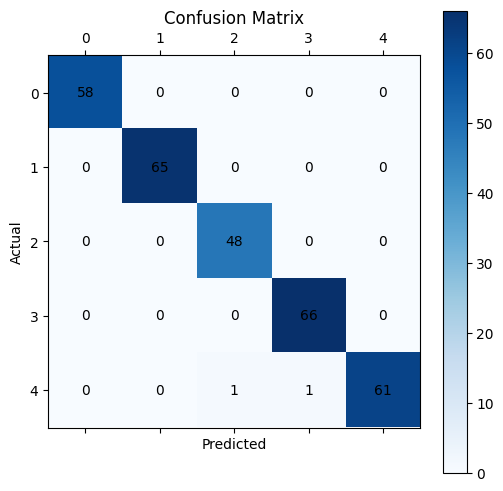

In [117]:
# A Model 5. VISUALIZATIONS confusion matrix
def plot_confusion_matrix(y_true, y_pred, n_classes=5):
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    fig.colorbar(cax)

    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))

    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, str(cm[i, j]), va='center', ha='center')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_true_indices, y_pred_indices, n_classes=5)

Documentation:

**1.Modification**

a) Output Neurons:

The output size was changed to 5, so the final weight matrix was updated to produce 5 outputs.
These 5 output neurons represent the probabilities for Class 0 to Class 4.

b) Deepening the Network Architecture (3 Hidden Layers):

The network structure was expanded to include three hidden layers instead of just one.Four separate weight matrices were initialized to connect these layers.


c) Implementation of Softmax Activation:

Softmax was added to the output layer to replace Sigmoid.Softmax ensures that the sum of all 5 output neurons equals 1. This converts raw scores into a valid probability distribution allowing the model to say, "There is a 90% chance this is Class A and 10% chance it is Class B."

d) Cross-Entropy Loss:

In the training part, the loss calculation was changed to Cross-Entropy.Mean is generally used for regression or binary tasks. Cross-Entropy is mathematically superior for multi-class classification because it heavily penalizes predictions that are confident but wrong.

e) Backpropagation:

The error calculation at the output layer was simplified.This is a mathematical shortcut.When Softmax activation combine with Cross-Entropy loss, the calculus simplifies so that the gradient is just the difference between the predicted probability and the actual label.

**2.Challenges Faced During Implementation & Solutions:**

a) Softmax (Overflow):

Large values in Softmax can cause overflow, so the exponential can't be calculated safely.

To fix this the maximum value is subtracted before applying exp,keeping the numbers stable.

b) Matrix Dimension Mismatches:

Transitioning from a single hidden layer to three hidden layers significantly increased the complexity of the matrix multiplications during Backpropagation. It was difficult to track the shapes of the weight matrices and error terms which was lead to Shape Mismatch errors when calculating gradients.

To fix that,I explicitly tracked the input and output sizes of every layer (input=2, hidden=30, output=5). During the backpropagation steps, I consistently used the Transpose operation (.T) on the weight matrices (e.g., self.W_H3O.T) to align the rows and columns correctly, ensuring the dot products could be computed successfully.



In [91]:
# B Model for comparison (less training high lr)

class NeuralNetwork_MultiClass(object):
    def __init__(self, input_size=2, hidden_size=30, output_size=5, learning_rate=0.01):
        #Input -> H1 -> H2 -> H3 -> Output
        self.inputLayerNeurons = input_size
        self.hiddenLayerNeurons = hidden_size
        self.outLayerNeurons = output_size
        self.learning_rate = learning_rate

        self.W_IH1 = np.random.randn(self.inputLayerNeurons, self.hiddenLayerNeurons) * 0.1
        self.W_H1H2 = np.random.randn(self.hiddenLayerNeurons, self.hiddenLayerNeurons) * 0.1
        self.W_H2H3 = np.random.randn(self.hiddenLayerNeurons, self.hiddenLayerNeurons) * 0.1
        self.W_H3O = np.random.randn(self.hiddenLayerNeurons, self.outLayerNeurons) * 0.1


    def sigmoid(self, x, der=False):
        if der == True:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        #Softmax activation for output layer (Multi-class).
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        # 1. Input - Hidden 1
        self.h1_input = np.dot(X, self.W_IH1)
        self.h1_output = self.sigmoid(self.h1_input)

        # 2. Hidden 1 - Hidden 2
        self.h2_input = np.dot(self.h1_output, self.W_H1H2)
        self.h2_output = self.sigmoid(self.h2_input)

        # 3. Hidden 2 - Hidden 3
        self.h3_input = np.dot(self.h2_output, self.W_H2H3)
        self.h3_output = self.sigmoid(self.h3_input)

        # 4. Hidden 3 - Output
        self.out_input = np.dot(self.h3_output, self.W_H3O)
        self.pred = self.softmax(self.out_input)

        return self.pred

    def backPropagation(self, X, Y, pred):
      # Error at Output (Cross Entropy + Softmax derivative is pred - Y)
        output_error = pred - Y
        output_delta = output_error

     # Propagate back through layers
        h3_error = output_delta.dot(self.W_H3O.T)
        h3_delta = h3_error * self.sigmoid(self.h3_output, der=True)

        h2_error = h3_delta.dot(self.W_H2H3.T)
        h2_delta = h2_error * self.sigmoid(self.h2_output, der=True)

        h1_error = h2_delta.dot(self.W_H1H2.T)
        h1_delta = h1_error * self.sigmoid(self.h1_output, der=True)

        self.W_H3O  -= self.learning_rate * self.h3_output.T.dot(output_delta)
        self.W_H2H3 -= self.learning_rate * self.h2_output.T.dot(h3_delta)
        self.W_H1H2 -= self.learning_rate * self.h1_output.T.dot(h2_delta)
        self.W_IH1  -= self.learning_rate * X.T.dot(h1_delta)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)


Epoch 0, Loss: 3.1470
Epoch 200, Loss: 1.6093
Epoch 400, Loss: 1.6082


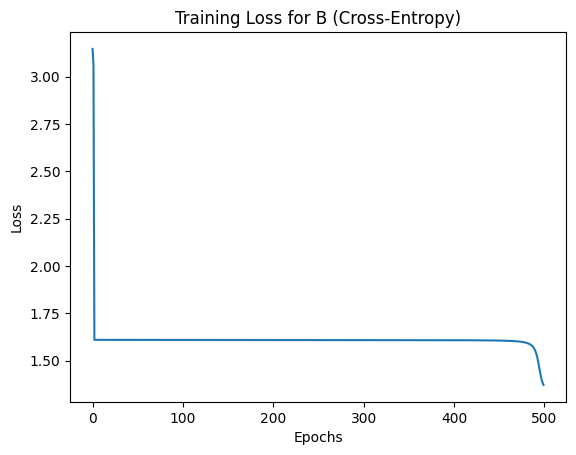

In [96]:
# B Model
NN = NeuralNetwork_MultiClass(input_size=2, hidden_size=30, output_size=5, learning_rate=0.01)
loss_history = []
epochs = 500
for i in range(epochs):
    NN.train(X_train, y_train)

    # Calculate Loss for graph
    predictions = NN.feedForward(X_train)
    epsilon = 1e-15
    clipped_preds = np.clip(predictions, epsilon, 1 - epsilon)
    loss = -np.mean(np.sum(y_train * np.log(clipped_preds), axis=1))
    loss_history.append(loss)

    if i % 200 == 0:
        print(f"Epoch {i}, Loss: {loss:.4f}")
# Plot Loss Curve
plt.plot(loss_history)
plt.title("Training Loss for B (Cross-Entropy)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [97]:
# B Model
# EVALUATION & METRICS
test_probs = NN.feedForward(X_test)
y_pred_indices = np.argmax(test_probs, axis=1)
y_true_indices = np.argmax(y_test, axis=1)

def calculate_metrics(y_true, y_pred, n_classes=5):
  #  print("\nPerformance Metrics")

    accuracy = np.mean(y_true == y_pred)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    precisions = []
    recalls = []
    f1_scores = []

    for c in range(n_classes):
        # True Positive, False Positive, False Negative
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"Class {c} | Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

In [98]:
# Calculate Metrics
calculate_metrics(y_true_indices, y_pred_indices, n_classes=5)

Overall Accuracy: 21.50%
Class 0 | Precision: 0.00, Recall: 0.00, F1: 0.00
Class 1 | Precision: 0.00, Recall: 0.00, F1: 0.00
Class 2 | Precision: 0.00, Recall: 0.00, F1: 0.00
Class 3 | Precision: 0.21, Recall: 1.00, F1: 0.35
Class 4 | Precision: 0.00, Recall: 0.00, F1: 0.00


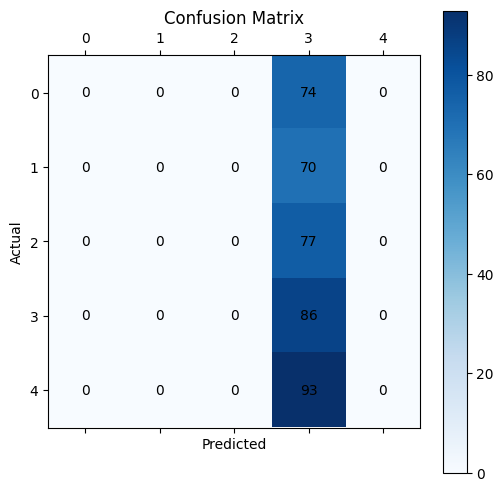

In [99]:
# B Model
def plot_confusion_matrix(y_true, y_pred, n_classes=5):
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    fig.colorbar(cax)

    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))

    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, str(cm[i, j]), va='center', ha='center')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_true_indices, y_pred_indices, n_classes=5)

**Results and Analysis**

The final model (Model A) was trained for 3,000 epochs with a learning rate of 0.0005.

1.Training Results:

The loss curve started at 1.61 and smoothly decreased to 0.017 by epoch 3000. This indicates a very stable and successful training process.

2.Testing Performance Metrics:

The model was evaluated on a held-out test set, achieving the following results:
Overall Accuracy: 99.33%

This high accuracy confirms that the 3-hidden-layer architecture is effective for this 5-class problem.

Class-wise Performance:

*   Class 0: Precision: 1.00, Recall: 1.00, F1-Score: 1.00
*  Class 1: Precision: 1.00, Recall: 1.00, F1-Score: 1.00

*   Class 2: Precision: 0.98, Recall: 1.00, F1-Score: 0.99
*   Class 3: Precision: 0.99, Recall: 1.00, F1-Score: 0.99

*   Class 4: Precision: 1.00, Recall: 0.97, F1-Score: 0.98


3. Visualization (Confusion Matrix):

The confusion matrix shows an almost perfect diagonal line.

There were negligible misclassifications ( only a tiny fraction of Class 4 was confused) proving the model effectively separated the 5 clusters.


**Observations & Insights**

1.Three Layers Provide Depth:

Observation: Moving from 1 hidden layer to 3 hidden layers allowed the model to draw more complex boundary lines between the 5 classes.
If we had used a simpler network, it might have struggled to separate the classes so cleanly. The extra layers give the model more "brain power" to understand the non-linear gaps between the data clusters.

2.Softmax is Essential for Multi-Class:

Observation: The output layer used the Softmax function to turn raw numbers into probabilities (percentages).
Without Softmax, the network would just spit out random numbers. Softmax forced the network to make a clear choice ("I am 90% sure this is Class 2"), which made calculating the error much more effective.

3.Learning Rate is a Sensitive Knob:

Observation: When the learning rate was high (0.01), the loss graph spiked unpredictably. When lowered to 0.0005, it became smooth than before.

4.Data Overlap Limits Perfection:

Observation: The model achieved an accuracy of 99.33%, indicating that the 3-hidden-layer architecture provided enough complexity to effectively separate the five classes. While perfect (100%) accuracy wasn't reached, the very few remaining errors (primarily small confusions in Class 4) suggest that the model has successfully overcome most data overlap issues.

**Compare the performance of model with different configurations and hyperparameters**

1.The Learning Rate Effect (The Main Factor)

Model A (0.0005): Because the step size was small, the model could carefully find the perfect weights to separate the 5 classes. This resulted in a smooth, downward line on the graph.

Model B (0.01): The step size was too large. The model kept missing the target causing it to get stuck immediately. It never actually learned anything, which is why the error stayed high.

2.The Accuracy Gap

Model A: With 99.33% accuracy, it correctly identified almost every single dot.

Model B: With 21.50% accuracy, it was basically guessing. Since there are 5 classes, a random guess gives you a 20% chance. Model B performed no better than a random coin toss.



**Conclusion**

**1.Summary of Key Findings:**

a) High Performance: The multi-class model performed exceptionally well, achieving an Overall Accuracy of 99.33%. This proves that the neural network successfully learned to distinguish between the five different classes of synthetic data.

b) Effective Architecture: Expanding the network from 1 hidden layer to 3 hidden layers provided the necessary "brain power" (complexity) to map the non-linear boundaries between the five clusters.

c) Crucial Role of Softmax: Replacing the binary Sigmoid function with Softmax in the output layer was essential. It allowed the model to treat the outputs as a probability distribution (99% Class A, 1% Class B") which is required for multi-class problems.

d) Hyperparameter Sensitivity: The most significant finding was the importance of the Learning Rate.

A high rate (0.01) caused the model to fail completely (21.5% accuracy).

A low rate (0.0005) allowed the model to learn smoothly and reach near-perfect results.

**Potential Improvements & Further Experiments**
a) Implement Adam Optimizer:

Why: Currently, we use a fixed learning rate (0.0005). The Adam optimizer automatically adjusts the speed for every single weight. It usually learns much faster and avoids the need for manual tuning guessing numbers.

b) Add "Dropout" Regularization:

Why: If we use real-world data which is messier than synthetic blobs, the model might memorize the training images overfitting. Dropout randomly turns off neurons during training, forcing the network to be more robust and adaptable.

c) Mini-Batch Training:

Why: Currently, the code feeds all training data at once. Feeding data in small chunks 32 images at a time)often leads to better generalization and faster training on larger datasets.

d) Early Stopping:

Why: We ran the model for exactly 3,000 epochs. An Early Stopping mechanism could monitor the loss and automatically stop training once the model stops improving (at epoch 2500), saving time and computing power.